In [1]:
#pip install pyarrow

import pyarrow as pa
import pyarrow.parquet as pq
import pandas as pd
import random
import string
from datetime import datetime, timedelta

# Define the schema for the log file
log_schema = pa.schema([
    ('timestamp', pa.timestamp('ms')),
    ('remote_host', pa.string()),
    ('request_method', pa.string()),
    ('request_endpoint', pa.string()),
    ('protocol', pa.string()),
    ('status_code', pa.int32()),
    ('content_size', pa.int64())
])

# Generate random log data
num_logs = 100000
logs = []

for i in range(num_logs):
    timestamp = datetime.now() - timedelta(days=random.randint(1, 30))
    remote_host = '.'.join([str(random.randint(0, 255)) for _ in range(4)])
    request_method = random.choice(['GET', 'POST', 'PUT', 'DELETE'])
    request_endpoint = '/' + ''.join(random.choices(string.ascii_lowercase + string.digits, k=random.randint(5, 15)))
    protocol = 'HTTP/1.1'
    status_code = random.choice([200, 404, 500, 302])
    content_size = random.randint(100, 10000)

    logs.append([timestamp, remote_host, request_method, request_endpoint, protocol, status_code, content_size])

# Create a PyArrow Table from the log data
log_table = pa.Table.from_pydict(dict(zip(log_schema.names, zip(*logs))), schema=log_schema)

# Convert the PyArrow Table to a Pandas DataFrame
log_df = log_table.to_pandas()

# Save the DataFrame as a Parquet file
pq.write_table(log_table, 'apache_logs.parquet')

In [2]:
# Initialize SparkSession
import matplotlib.pyplot as plt
from pyspark.sql.functions import *
from pyspark.sql import SparkSession, Window
spark = SparkSession.builder.appName("Generate Sample Apache Logs").getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/05/20 18:08:51 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
24/05/20 18:08:51 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


In [3]:
logs_df = spark.read.parquet("apache_logs.parquet")

In [4]:
logs_df.show(5, truncate=False)

+-----------------------+---------------+--------------+----------------+--------+-----------+------------+
|timestamp              |remote_host    |request_method|request_endpoint|protocol|status_code|content_size|
+-----------------------+---------------+--------------+----------------+--------+-----------+------------+
|2024-04-23 18:08:45.344|189.74.74.146  |GET           |/b8u1r          |HTTP/1.1|500        |3915        |
|2024-04-29 18:08:45.344|129.48.189.248 |GET           |/lrub2us0x8bnh2 |HTTP/1.1|302        |4969        |
|2024-05-11 18:08:45.344|66.18.19.33    |POST          |/ivqe9f4qqqfpn  |HTTP/1.1|404        |2404        |
|2024-05-03 18:08:45.344|180.247.206.156|POST          |/e09vnw2y7hosv  |HTTP/1.1|404        |3701        |
|2024-05-13 18:08:45.344|89.240.111.26  |DELETE        |/r2lqk          |HTTP/1.1|200        |2488        |
+-----------------------+---------------+--------------+----------------+--------+-----------+------------+
only showing top 5 rows



In [5]:
# Traffic Analysis: Top Endpoints
top_endpoints = logs_df.groupBy("request_endpoint").count().orderBy("count", ascending=False)
top_endpoints.show(10)

+----------------+-----+
|request_endpoint|count|
+----------------+-----+
|          /bg5bq|    1|
|         /yktuhw|    1|
|    /07f7i2ffhdh|    1|
|     /4gizyjp319|    1|
|  /4gqt669wrgjtu|    1|
|/dpai2cwzkeqg4ek|    1|
|/l1nfuupt6e87zqj|    1|
|/mbvfro07iqv6pqy|    1|
|       /48rtc3p3|    1|
|  /56ndc23yi9lrm|    1|
+----------------+-----+
only showing top 10 rows



In [6]:
# Cast content_size to integer
logs_df = logs_df.withColumn("content_size", col("content_size").cast("int"))

In [7]:
# Top endpoints transferring maximum content
top_endpoints_by_content = logs_df.groupBy("request_endpoint").sum("content_size") \
    .orderBy(desc("sum(content_size)")).withColumnRenamed("sum(content_size)", "total_content_size")
top_endpoints_by_content.show(10)

+----------------+------------------+
|request_endpoint|total_content_size|
+----------------+------------------+
|   /8u23qivfayue|             10000|
|     /6edza5ajr3|             10000|
|          /ylzg6|             10000|
|     /umzpc6hy1c|             10000|
|    /o7so55fi9bn|             10000|
|/a1w5l5b4hsm7u18|             10000|
| /u04r6efbq1iicb|             10000|
|     /sx3dda4lcy|             10000|
|      /6paxg5u6g|              9999|
|      /e17ivscia|              9999|
+----------------+------------------+
only showing top 10 rows



In [8]:
frequent_visitors = logs_df.groupBy("remote_host").count().filter(col("count") >= 1).orderBy("count", ascending=False)
frequent_visitors.show()

+---------------+-----+
|    remote_host|count|
+---------------+-----+
|  98.154.144.89|    2|
|    3.25.48.198|    1|
| 201.135.212.32|    1|
|  15.32.153.164|    1|
|   64.20.227.83|    1|
| 37.179.158.180|    1|
| 152.191.195.23|    1|
|  102.55.245.83|    1|
|  42.105.224.40|    1|
| 178.159.233.81|    1|
|  154.28.108.64|    1|
|111.142.211.151|    1|
|  71.68.118.219|    1|
|   243.74.59.99|    1|
|148.249.220.126|    1|
|  170.191.63.49|    1|
| 18.172.103.151|    1|
|148.204.134.220|    1|
|    5.157.43.17|    1|
|  68.210.194.76|    1|
+---------------+-----+
only showing top 20 rows



In [9]:
# Calculating statistics related to content size 
content_size_stats = logs_df.select( min("content_size").alias("min_content_size"),
                                     max("content_size").alias("max_content_size"),
                                     avg("content_size").alias("total_requests"),
                                     count("content_size").alias("total_requests"))
content_size_stats.show()


+----------------+----------------+--------------+--------------+
|min_content_size|max_content_size|total_requests|total_requests|
+----------------+----------------+--------------+--------------+
|             100|           10000|    5049.87157|        100000|
+----------------+----------------+--------------+--------------+



In [10]:
# Anomaly Detection
#IPs with More Than 10 Requests

anomalous_ips = logs_df.groupBy("remote_host").count().filter(col("count") >= 10)
anomalous_ips.show()

+-----------+-----+
|remote_host|count|
+-----------+-----+
+-----------+-----+



In [11]:
# 404 Requests

latest_404_requests = logs_df.filter(col("status_code") == 404).orderBy(col("timestamp"),\
                       ascending=False).select("timestamp", "request_endpoint").limit(10)

latest_404_requests.show(truncate=False)

+-----------------------+----------------+
|timestamp              |request_endpoint|
+-----------------------+----------------+
|2024-05-19 18:08:46.512|/tazajfc        |
|2024-05-19 18:08:46.51 |/pzcbbj         |
|2024-05-19 18:08:46.51 |/q6bz75gaa6q5e  |
|2024-05-19 18:08:46.507|/fb2i9usc       |
|2024-05-19 18:08:46.507|/83uol6zn0ioevw7|
|2024-05-19 18:08:46.507|/tr04069l       |
|2024-05-19 18:08:46.506|/wtlr787p4g     |
|2024-05-19 18:08:46.506|/zwe78s         |
|2024-05-19 18:08:46.502|/iymq7udtk8nn   |
|2024-05-19 18:08:46.501|/2lqy2r7kpg     |
+-----------------------+----------------+



In [20]:
# Analyze bad requests (404 errors)
bad_requests = logs_df.filter(col("status_code") == 404).orderBy(desc("timestamp")).select("request_endpoint", "timestamp")
bad_requests_partitioned = bad_requests.withColumn("date", to_date(col("timestamp")))
window = Window.partitionBy("date").orderBy(desc("timestamp"))
bad_requests_top10 = bad_requests_partitioned.withColumn("row_num", row_number().over(window)).filter(col("row_num") <= 10).\
drop("row_num", "date")
bad_requests_top10.show(truncate = False)

+----------------+-----------------------+
|request_endpoint|timestamp              |
+----------------+-----------------------+
|/fodqjfng97qef  |2024-04-20 18:08:46.513|
|/x2j1vimo3saq   |2024-04-20 18:08:46.511|
|/sbzikq         |2024-04-20 18:08:46.508|
|/1d8idad        |2024-04-20 18:08:46.507|
|/q66a1ukr6t     |2024-04-20 18:08:46.503|
|/vrpiyoa        |2024-04-20 18:08:46.501|
|/dh0m199vrj6ys  |2024-04-20 18:08:46.499|
|/yh935f         |2024-04-20 18:08:46.498|
|/yy18gkrdgqb4   |2024-04-20 18:08:46.497|
|/ndlly          |2024-04-20 18:08:46.496|
|/edm1df4pn2     |2024-04-21 18:08:46.514|
|/gszoueq        |2024-04-21 18:08:46.513|
|/lusy6h         |2024-04-21 18:08:46.512|
|/g5ti88         |2024-04-21 18:08:46.511|
|/mqkya6jpvhkuhs0|2024-04-21 18:08:46.511|
|/usq8h6th       |2024-04-21 18:08:46.506|
|/wbfov          |2024-04-21 18:08:46.506|
|/yjc4qlxv39mej  |2024-04-21 18:08:46.504|
|/qxcxj4wlbvy7   |2024-04-21 18:08:46.5  |
|/6bigjwy7gae4g  |2024-04-21 18:08:46.499|
+----------

In [12]:
# Count of Requests by HTTP Method
requests_by_method = logs_df.groupBy("request_method").count().orderBy("request_method")
requests_by_method.show()

+--------------+-----+
|request_method|count|
+--------------+-----+
|        DELETE|24869|
|           GET|25190|
|          POST|24802|
|           PUT|25139|
+--------------+-----+



In [13]:
# Response Code Analysis
response_code_analysis = logs_df.groupBy("status_code").count().orderBy("status_code")
response_code_analysis.show()

+-----------+-----+
|status_code|count|
+-----------+-----+
|        200|24906|
|        302|24957|
|        404|24952|
|        500|25185|
+-----------+-----+



In [14]:
# Calculate percentage of successful requests
total_requests = logs_df.count()
successful_requests = logs_df.filter(col("status_code") == 200).count()
error_requests = total_requests - successful_requests
success_percentage = (successful_requests / total_requests) * 100
error_percentage = 100 - success_percentage
print(f"Successful Requests: {success_percentage:.2f}%")
print(f"Error Requests: {error_percentage:.2f}%")


Successful Requests: 24.91%
Error Requests: 75.09%


In [15]:
# Top visited endpoints
top_visited_endpoints = logs_df.groupBy("request_endpoint").count() \
    .orderBy(desc("count")).withColumnRenamed("count", "visit_count")
top_visited_endpoints.show(10)

+----------------+-----------+
|request_endpoint|visit_count|
+----------------+-----------+
|          /bg5bq|          1|
|         /yktuhw|          1|
|    /07f7i2ffhdh|          1|
|     /4gizyjp319|          1|
|  /4gqt669wrgjtu|          1|
|/dpai2cwzkeqg4ek|          1|
|/l1nfuupt6e87zqj|          1|
|/mbvfro07iqv6pqy|          1|
|       /48rtc3p3|          1|
|  /56ndc23yi9lrm|          1|
+----------------+-----------+
only showing top 10 rows



In [16]:
# Daily visited content size
daily_content_size = logs_df.withColumn("date", to_date(col("timestamp"))).groupBy("date").agg(sum("content_size").alias("daily_content_size")).orderBy("date")
daily_content_size.show()

+----------+------------------+
|      date|daily_content_size|
+----------+------------------+
|2024-04-20|          16022171|
|2024-04-21|          17058708|
|2024-04-22|          17259726|
|2024-04-23|          16165858|
|2024-04-24|          17462657|
|2024-04-25|          16861813|
|2024-04-26|          17181444|
|2024-04-27|          16844468|
|2024-04-28|          17183367|
|2024-04-29|          16929947|
|2024-04-30|          16454773|
|2024-05-01|          17133472|
|2024-05-02|          16908708|
|2024-05-03|          16752894|
|2024-05-04|          17043402|
|2024-05-05|          16666389|
|2024-05-06|          17062423|
|2024-05-07|          16857154|
|2024-05-08|          16729244|
|2024-05-09|          16312687|
+----------+------------------+
only showing top 20 rows



In [17]:

# Top endpoints transferring maximum content
top_content_endpoints = (
    logs_df.groupBy("request_endpoint")
    .agg(sum("content_size").alias("total_content"))
    .orderBy(desc(cast("total_content", lit("string")))).limit(10)
)
top_content_endpoints.show()


+----------------+-------------+
|request_endpoint|total_content|
+----------------+-------------+
|          /bg5bq|         8660|
|         /yktuhw|         1619|
|    /07f7i2ffhdh|         3886|
|     /4gizyjp319|         4338|
|  /4gqt669wrgjtu|         8861|
|/dpai2cwzkeqg4ek|         6962|
|/l1nfuupt6e87zqj|          702|
|/mbvfro07iqv6pqy|         5890|
|       /48rtc3p3|         5813|
|  /56ndc23yi9lrm|         8063|
+----------------+-------------+



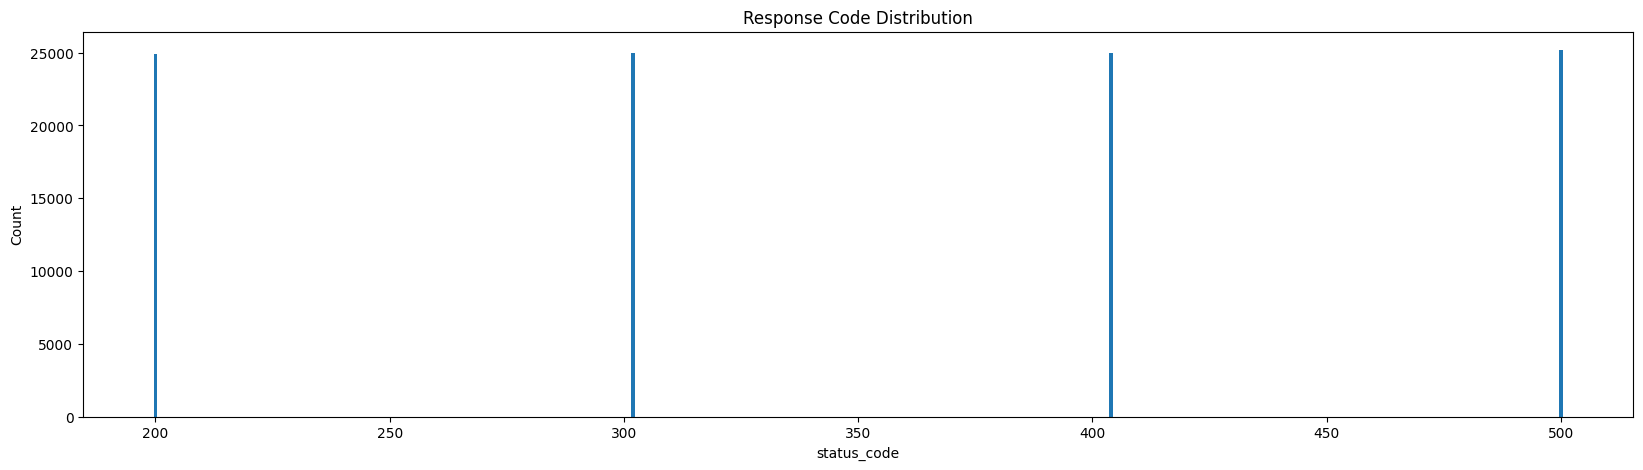

In [18]:
# Analyze response codes
response_code_counts = logs_df.groupBy("status_code").agg(count("*").alias("count")).orderBy(desc("count"))

# Example: Plot response code distribution
response_code_pandas = response_code_counts.toPandas()

plt.figure(figsize=(20, 5))
plt.bar(response_code_pandas['status_code'], response_code_pandas['count'])
plt.xlabel('status_code')
plt.ylabel('Count')
plt.title('Response Code Distribution')
plt.show()